# **The impact of ENSO on precipitation and temperature**

**Content creators:** Olawale Ikuyajolu & Patrick Orenstein

**Content reviewers:** Marguerite Brown, Yuxin Zhou

**Content editors:** Zane Mitrevica, Natalie Steinemann, Ohad Zivan, Chi Zhang , Jenna Pearson 

**Production editors:** TBD

**Our 2023 Sponsors:** NASA TOPS, Google deepmind

To understand the historical and future impacts of El Niño Southern Oscillation (ENSO) events on rainfall and temperature, you will work with climate model output, reanalysis data, and Niño 3.4 indices from CMIP5/6, ERA5, NOAA, and HadISST, focusing on variables like sea surface temperature, surface air temperature, and precipitation. You will also be able to investigate the relationships between these variables and how they affect community efforts to prepare for the impacts of El Niño phases.

Recall W2D1 (Week 2 Day 1) tutorials on CMIP6 and read more about the different CMIP6 [here](https://www.dkrz.de/en/communication/climate-simulations/cmip6-en/the-ssp-scenarios).


In [1]:
# @title Video 1: Speaker Introduction
# Tech team will add code to format and display the video

# **Project quesions**

![Project quuesions](https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/1642e41798d4c7522ce45cc554d616da264ef5dc/projects/template-images/ENSO_template_map.svg)

# **Data exploration notebook**
## **Project setup**

Please run the following cells!

In [1]:
# google colab installs

# !pip install condacolab &> /dev/null
# import condacolab
# condacolab.install()

# # Install all packages in one call (+ use mamba instead of conda)
# !mamba install xarray-datatree intake-esm gcsfs xmip aiohttp cartopy nc-time-axis cf_xarray xarrayutils "esmf<=8.3.1" xesmf &> /dev/null

In [2]:
# imports
import time

tic = time.time()

import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
from xmip.preprocessing import combined_preprocessing
from xarrayutils.plotting import shaded_line_plot
from datatree import DataTree
from xmip.postprocessing import _parse_metric
import cartopy.crs as ccrs
import pooch

In [3]:
# Functions

%matplotlib inline

col = intake.open_esm_datastore(
    "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
)  # open an intake catalog containing the Pangeo CMIP cloud data


def load_cmip6(source_id, variable_id, member_id, table_id):  # load selected model
    cat = col.search(
        source_id=source_ids,
        variable_id=variable_id,
        member_id=member_id,
        table_id=table_id,
        grid_label="gn",
        experiment_id=[
            "historical",
            "ssp126",
            "ssp245",
            "ssp585",
        ],  # downloading the scenarios out of the total 5+historical
        require_all_on=["source_id"],
    )

    kwargs = dict(
        preprocess=combined_preprocessing,
        xarray_open_kwargs=dict(use_cftime=True),
        storage_options={"token": "anon"},
    )
    cat.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
    dt = cat.to_datatree(**kwargs)

    return dt

## **Dataset 1: Load CMIP6 Model of your choice**

Following W2D1 (Week 2 Day 1) tutorial notebooks

  * We use *r4i1p1f1 and CESM2* as the template, but you are free to select any model. Make sure the member_id selected is available for your model
  
  * `load_cmip6` function load both historical and ssp585 (future: climate change) 




In [11]:
# pick your model

source_ids = "CESM2"

dm_tas = load_cmip6(
    source_ids, "tas", "r4i1p1f1", "Amon"
)  # tas is atmoerhpere temprature
dm_pr = load_cmip6(source_ids, "pr", "r4i1p1f1", "Amon")  # pr is precipitation rate
dm_sst = load_cmip6(
    source_ids, "tos", "r4i1p1f1", "Omon"
)  # tos is surface ocean temprature
print(
    dm_tas.keys()
)  # an example for one of the datatrees, you can duplicate this for the other DT


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


KeysView(DataTree('None', parent=None)
└── DataTree('CESM2')
    ├── DataTree('ssp245')
    │       Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1032, y: 192,
    │                            x: 288, nbnd: 2)
    │       Coordinates:
    │         * y               (y) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    │         * x               (x) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    │         * time            (time) object 2015-01-15 12:00:00 ... 2100-12-15 12:00:00
    │           lon_bounds      (x, nbnd, y) float64 dask.array<chunksize=(288, 2, 192), meta=np.ndarray>
    │           time_bounds     (time, nbnd) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
    │           lat_bounds      (y, nbnd, x) float64 dask.array<chunksize=(192, 2, 288), meta=np.ndarray>
    │         * nbnd            (nbnd) int64 0 1
    │           lon             (x, y) float64 360.0 360.0 360.0 360.0 ... 358.8 358.8 358.8
    │           lat     

In [12]:
# Load cell areas for computing ocean surface temparuters means

dt_ocean_area = load_cmip6(source_ids, "areacello", "r4i1p1f1", "Ofx")
dt_atmos_area = load_cmip6(source_ids, "areacella", "r4i1p1f1", "fx")

dt_ocean_with_area = DataTree()
dt_atmos_with_area = DataTree()

for model, subtree in dm_sst.items():
    metric_ocean = dt_ocean_area[model]["historical"].ds["areacello"]
    dt_ocean_with_area[model] = subtree.map_over_subtree(_parse_metric, metric_ocean)

for model, subtree in dm_pr.items():
    metric_atmos = dt_atmos_area[model]["historical"].ds["areacella"]
    dt_atmos_with_area[model] = subtree.map_over_subtree(_parse_metric, metric_atmos)

print(dt_ocean_with_area.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


KeysView(DataTree('None', parent=None)
└── DataTree('CESM2')
    ├── DataTree('historical')
    │       Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1980, y: 384,
    │                            x: 320, bnds: 2, vertex: 4)
    │       Coordinates: (12/13)
    │           lat             (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    │           lon             (y, x) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    │         * time            (time) object 1850-01-15 12:59:59.999997 ... 2014-12-15 1...
    │           time_bounds     (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
    │           lon_verticies   (y, x, vertex) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    │           lat_verticies   (y, x, vertex) float32 dask.array<chunksize=(384, 320, 4), meta=np.ndarray>
    │           ...              ...
    │         * x               (x) int64 0 1 2 3 4 5 6 7 ... 313 314 315 316 317 318 3

## **Dataset 2: Load Observations**

We use the NOAA Extended Reconstructed Sea Surface Temperature (ERSST) v5 product, a widely used and trusted gridded compilation of of historical data going back to 1854.Since the data is provided via an OPeNDAP server, we can load it directly without downloading anything

We use CPC Merged Analysis of Precipitation (CMAP) for precipitation. We download this dataset from NOAA PSL, Boulder, Colorado, USA website at https://psl.noaa.gov

For air temperature, we are using anomalies from NASA GISS Surface Temperature Analysis. Also from from NOAA PSL, Boulder, Colorado, USA website at https://psl.noaa.gov


In [1]:
# Ocean surface temprature
url_SST = (
    "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc"
)
do_sst = xr.open_dataset(url_SST, drop_variables=["time_bnds"])

# Precipitation rate (notice the units in the plot below)
do_pr = xr.open_dataset(
    pooch.retrieve(
        "https://downloads.psl.noaa.gov/Datasets/cmap/enh/precip.mon.mean.nc",
        known_hash=None,
    )
)

# Air Temperature Anomalies
do_tas = xr.open_dataset(
    pooch.retrieve(
        "https://downloads.psl.noaa.gov/Datasets/gistemp/combined/1200km/air.2x2.1200.mon.anom.comb.nc",
        known_hash=None,
    )
)

NameError: name 'xr' is not defined

We can now visualize the content of the dataset.



Text(0.5, 1.0, 'July 2000')

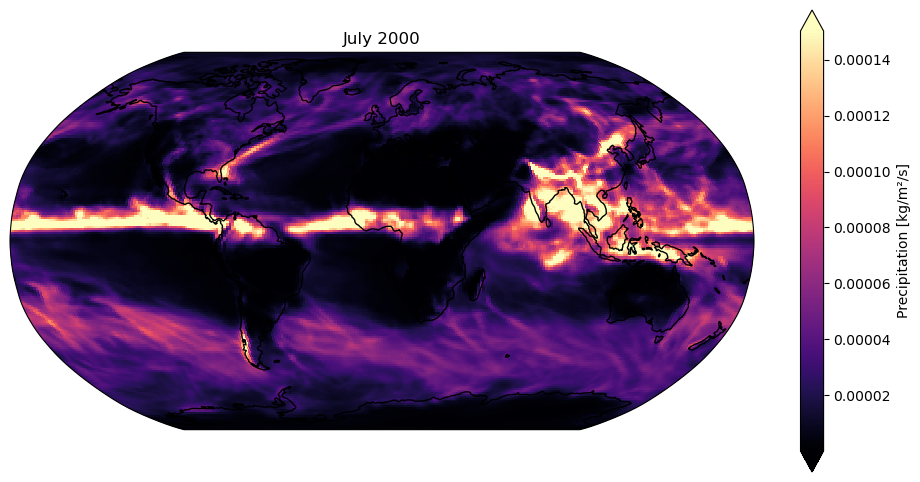

In [9]:
# Code to print the shape, array names, etc of the dataset

# select just a single model and experiment
hist_precip = dm_pr["CESM2"]["historical"].ds.pr

fig, ax_july2000 = plt.subplots(
    ncols=1, nrows=1, figsize=[12, 6], subplot_kw={"projection": ccrs.Robinson()}
)

# plot a timestep for 2000
sst_July2000 = (
    hist_precip.sel(time="2000-07")
    .squeeze()
    .plot(ax=ax_july2000, transform=ccrs.PlateCarree(), cmap="magma", robust=True)
)
ax_july2000.coastlines()
ax_july2000.set_title("July 2000")

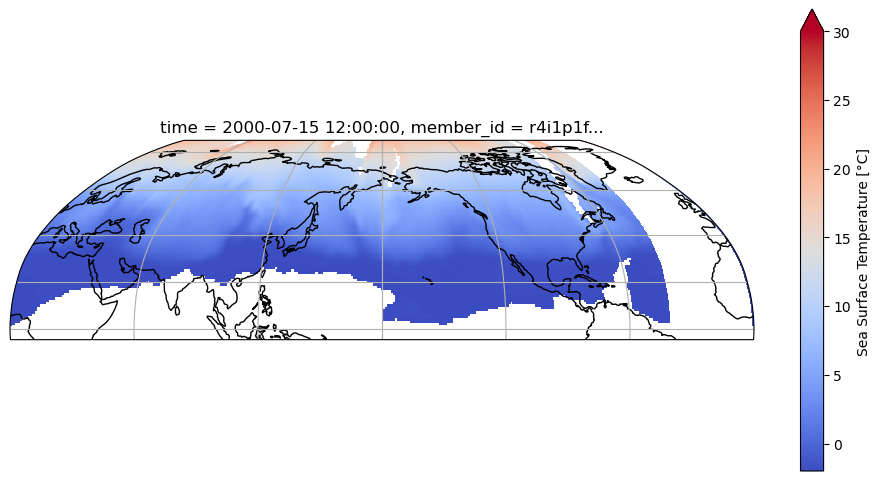

In [19]:
hist_sst = dm_sst["CESM2"]["historical"].ds.tos

fig, ax = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=[12, 6],
    subplot_kw={"projection": ccrs.Robinson(central_longitude=180)},
)

ax.coastlines()
ax.gridlines()
hist_sst.sel(time="2000-07").squeeze().plot(
    ax=ax, transform=ccrs.PlateCarree(), vmin=-2, vmax=30, cmap="coolwarm"
)

## **Dataset 3: Nino 3.4 Index:**

In [13]:
# get El Nino data from W1D3 tutorial 7
url_nino = "https://osf.io/8rwxb/download/"
oni = xr.open_dataset(pooch.retrieve(url_nino, known_hash=None))
print(oni.keys())

KeysView(<xarray.Dataset>
Dimensions:  (time: 499)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2023-03-01
    month    (time) int32 ...
Data variables:
    sst      (time) float32 ...)


Now that you have loaded and visualized the data, we are all set to find and answer a meaningful research question!